In [12]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, requests, censusdata, zipfile
from pathlib import Path

## 1. US county demographic data EDA
####  1.1 Set raw and processed data directories

In [14]:
raw_dir = Path('../raw_data/')
processed_dir = Path('../processed_data/')

assert(raw_dir.exists() & processed_dir.exists()), 'data directories not valid'

#### 1.2 Pull downloaded Kaggle data (requires auth) 
Basic county-level demographic data from JHU and US Census was downloaded from Kaggle to a CSV since download requires username / password authentication. The data contains the unique FIPS code, county / state names, male and female populations, median county age, as well as the latitude and longitude of the center of the county.

In [5]:
kaggle_demos = pd.read_csv(raw_dir/'us_county.csv')
kaggle_demos.head()

,fips,county,state,state_code,male,female,median_age,population,female_percentage,lat,long
0,1001,Autauga County,Alabama,AL,26874,28326,37.8,55200,51.315217,32.534923,-86.642730
1,1003,Baldwin County,Alabama,AL,101188,106919,42.8,208107,51.376936,30.727479,-87.722564
2,1005,Barbour County,Alabama,AL,13697,12085,39.9,25782,46.873788,31.869581,-85.393210
3,1007,Bibb County,Alabama,AL,12152,10375,39.9,22527,46.055844,32.998628,-87.126475
4,1009,Blount County,Alabama,AL,28434,29211,40.8,57645,50.673953,33.980869,-86.567380


#### 1.3 Request IHME health data

Some additional health data was downloaded from the Institute for Health Metrics and Evaluation (IHME). The data contains time series records of mortality risk and life expectancy measures across every county for several age ranges dating back to the 1980s. We cleaned and standardized this data to only include the most recent sample of county average life expectancy at birth and mortality risk for the 65 to 85 year old population (the most vulnerable to the effects of COVID-19). The data also includes a FIPS code.

In [6]:
if 'ihme_health.csv' not in [_.name for _ in raw_dir.glob('*')]:
    h_url = 'http://ghdx.healthdata.org/sites/default/files/record-attached-files/'
    h_file = 'IHME_USA_COUNTY_LE_MORTALITY_RISK_1980_2014_NATIONAL_STATES_DC_CSV.zip'
    r = requests.get(h_url+h_file, stream=True)
    with open(raw_dir/'ihme_health.zip', 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)
    with zipfile.ZipFile(raw_dir/'ihme_health.zip', 'r') as zip_ref:
        zip_ref.extractall(raw_dir/'imhe_health/')
    health_pth = Path(raw_dir/'imhe_health/')
    assert health_pth.exists(), 'no health files found'
    files = health_pth.glob('*.csv')
    
    health_dfs = []
    for f in files:
        try:
            df = pd.read_csv(f)
            max_year = df.year_id.max()
            # logic to get single rows for pivot table
            df = df[(df.year_id == max_year) & (df.sex == "Both") \
                    & ((df.age_name == "0") | (df.age_name == "65 to 85"))]
            pvt = pd.pivot_table(df, values = 'val', columns = 'measure_name',
                    index=['FIPS', 'location_name']).reset_index()
            health_dfs.append(pvt)
        except Exception as e:
            print(e); continue
            
    health = pd.concat([_ for _ in health_dfs if _.shape[0] > 1])
    health.to_csv(raw_dir/'ihme_health.csv')
else:
    health = pd.read_csv(raw_dir/'ihme_health.csv')

'>=' not supported between instances of 'str' and 'float'


In [7]:
health.head()

measure_name,FIPS,location_name,Life expectancy,Mortality risk
0,1,Alabama,75.648292,57.460523
1,1001,Autauga County,75.668023,58.373616
2,1003,Baldwin County,78.075681,50.486669
3,1005,Barbour County,75.421683,56.251879
4,1007,Bibb County,73.967404,61.110046


#### 1.4 Census income data

We downloaded county-level income data from the most recent Census survey (2018) and processed the data to find the estimated number of impoverished people in each county, as well as the median household income. The data again includes a FIPS code.

In [8]:
r = requests.get('https://www2.census.gov/programs-surveys/saipe/datasets/2018/2018-state-and-county/est18all.txt')
t = r.text

lines = t.split('\n')
income_dict = {}
for l in lines:
    name = l[193:238].strip()
    if name == '': continue
    fin_demos = {
        'fips_state': l[0:2].strip(),
        'fips_county': l[3:6].strip(),
        'all_poverty': l[7:15].strip(),
        'median_hh_income': l[133:139].strip()
    }
    income_dict[name] = fin_demos

income = pd.DataFrame(income_dict).T
def fix_fips(s):
    if len(s) == 3: return s
    elif len(s) == 2: return f'0{s}'
    else: return f'00{s}'
    
# fix erros in Kalawao county
income = income.replace('.', np.nan)
income['all_poverty'] = income.all_poverty.astype(float)
income['median_hh_income'] = income.median_hh_income.astype(float)

income['fips_county_pad'] = income.fips_county.map(fix_fips)
income['fips'] = (income.fips_state + income.fips_county_pad).astype(int)
income.head()

,fips_state,fips_county,all_poverty,median_hh_income,fips_county_pad,fips
United States,00,0,41852315.0,61937.0,000,0
Alabama,01,0,801758.0,49881.0,000,1000
Autauga County,01,1,7587.0,59338.0,001,1001
Baldwin County,13,9,9313.0,42727.0,009,13009
Barbour County,54,1,3110.0,39776.0,001,54001


#### 1.5 Land area

In [26]:
landvar = 'LND110210D'
land = pd.read_csv(raw_dir/'LND01.csv')[['STCOU', landvar]].rename(
    columns={'STCOU':'fips', landvar:'sq_miles'})
land.head()

,fips,sq_miles
0,0,3531905.43
1,1000,50645.33
2,1001,594.44
3,1003,1589.78
4,1005,884.88


#### 1.5 Merge

We merge all of these datasets on FIPS code.

In [27]:
demos = pd.merge(
    kaggle_demos, health.set_index('FIPS')[['Life expectancy', 'Mortality risk']],
    left_on='fips', right_index=True).merge(
        income.set_index('fips')[['all_poverty', 'median_hh_income']],
        left_on='fips', right_index=True).merge(
            land.set_index('fips'), left_on='fips', right_index=True)

def fix_colname(s): return s.lower().strip().replace(' ', '_')
demos.columns = [fix_colname(_) for _ in demos.columns]

#### Enrich

In [29]:
demos['pct_impoverished'] = demos.all_poverty.div(demos.population)
demos['pop_density'] = demos.population.div(demos.sq_miles)

#### Quick vis check

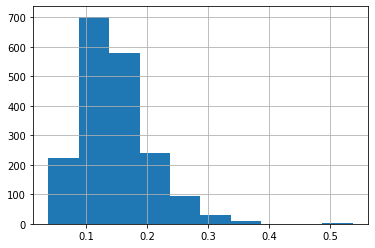

In [10]:
demos.pct_impoverished.hist()

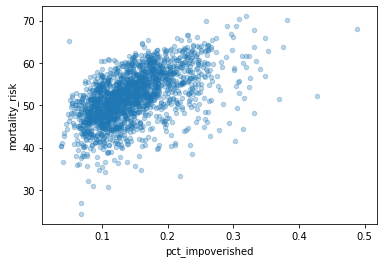

In [40]:
demos.plot.scatter('pct_impoverished', 'mortality_risk', alpha=0.3)

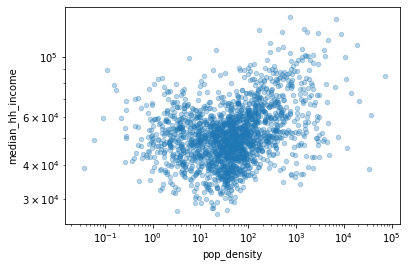

In [41]:
demos.plot.scatter('pop_density', 'median_hh_income', alpha=0.3)
plt.xscale('log'); plt.yscale('log')

In [42]:
demos.corr()

,fips,male,female,median_age,population,female_percentage,lat,long,life_expectancy,mortality_risk,all_poverty,median_hh_income,sq_miles,pct_impoverished,pop_density
fips,1.000000,-0.098132,-0.097480,0.028842,-0.097812,0.010775,-0.033961,0.229549,0.010738,0.055588,-0.089587,0.002788,-0.153508,-0.080275,0.011681
male,-0.098132,1.000000,0.999540,-0.167196,0.999881,0.104826,-0.075862,-0.026663,0.181282,-0.195604,0.966077,0.268450,0.025827,-0.086238,0.304061
female,-0.097480,0.999540,1.000000,-0.165271,0.999889,0.112388,-0.076597,-0.019431,0.179987,-0.195745,0.968324,0.266620,0.023662,-0.084458,0.318997
median_age,0.028842,-0.167196,-0.165271,1.000000,-0.166237,0.065354,0.146879,0.105256,0.128264,-0.164528,-0.178152,-0.116088,-0.087729,-0.177561,-0.101456
population,-0.097812,0.999881,0.999889,-0.166237,1.000000,0.108680,-0.076244,-0.022993,0.180645,-0.195698,0.967330,0.267551,0.024730,-0.085343,0.311684
female_percentage,0.010775,0.104826,0.112388,0.065354,0.108680,1.000000,-0.101288,0.245399,-0.060081,0.066979,0.108020,0.011766,-0.154093,0.005892,0.094064
lat,-0.033961,-0.075862,-0.076597,0.146879,-0.076244,-0.101288,1.000000,-0.285998,0.389142,-0.326487,-0.099652,0.246477,0.289309,-0.368150,0.004313
long,0.229549,-0.026663,-0.019431,0.105256,-0.022993,0.245399,-0.285998,1.000000,-0.170882,0.261475,-0.019038,-0.101058,-0.386676,0.057228,0.107124
life_expectancy,0.010738,0.181282,0.179987,0.128264,0.180645,-0.060081,0.389142,-0.170882,1.000000,-0.946702,0.117484,0.639550,-0.014304,-0.691667,0.098339
mortality_risk,0.055588,-0.195604,-0.195745,-0.164528,-0.195698,0.066979,-0.326487,0.261475,-0.946702,1.000000,-0.149922,-0.544292,-0.048142,0.548981,-0.143074
